# DB generalization experiment
Question: how accurate is our cost model if we have not seen any queries for a new customer?

In [2]:

import os
import string
from copy import copy

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experiments.evaluation.utils import read_csvs, FilenameAttribute, read_zero_shot_generalization
from experiments.evaluation.utils import prepare_df, get_plotting_info, Approaches, ZeroShotConfiguration
from experiments.evaluation.utils import get_zero_shot_configs

plt.rc('text', usetex=True)
sns.set_theme(style="whitegrid", font_scale=1.5)

In [3]:
def read_zero_shot_synthetic():
    dfs_zero_shot = []
    for c in get_zero_shot_configs(include_deepdb=False, include_est=True):
        dir = f'../data/syn_benchmarks_{c.folder_name}'
        if not os.path.exists(dir):
            continue

        exp_cards = read_csvs(dir, [FilenameAttribute('dataset', pos=0),
                                    FilenameAttribute('workload', pos=2, end_pos=-1),
                                    FilenameAttribute('approach', default=c.name)],
                              complex_only=False)
        dfs_zero_shot.append(exp_cards)
    return pd.concat(dfs_zero_shot)

all_dfs = []
all_dfs.append(read_csvs('../data/e2e_baseline/db_generalization', [FilenameAttribute('dataset', pos=1),
                                                                    FilenameAttribute('approach', pos=0),
                                                                    FilenameAttribute('workload', pos=3)]))
all_dfs.append(read_csvs('../data/e2e_baseline/db_generalization_complex', [FilenameAttribute('dataset', pos=1),
                                                                            FilenameAttribute('approach', pos=0),
                                                                            FilenameAttribute('workload', pos=3)],
                         complex_only=True))
all_dfs.append(read_csvs('../data/e2e_baseline/syn_benchmarks', [FilenameAttribute('dataset', pos=1),
                                                                    FilenameAttribute('approach', pos=0),
                                                                    FilenameAttribute('workload', pos=3, end_pos=-1)]))
all_dfs.append(read_zero_shot_generalization())
all_dfs.append(read_zero_shot_synthetic())
df_generalization = pd.concat(all_dfs)


In [5]:
def compare(approach_l, approach_r, workload='Numeric', df_all=None):
    comp_df = df_all[df_all.workload == workload]
    comp_df = comp_df[['dataset', 'approach', 'val_median_q_error_50', 'val_median_q_error_95',
                       'val_median_q_error_100']].groupby(['dataset', 'approach']).mean().reset_index()
    comp_df_l = comp_df[comp_df.approach == approach_l]
    comp_df_r = comp_df[comp_df.approach == approach_r]
    comp_m = comp_df_l.merge(comp_df_r, on=['dataset'], suffixes=('_l', '_r'))

    approach_labels = {a.value.name: a.value.label.replace('\n', '') for a in list(Approaches)}

    print(f'\nComparing {approach_labels[approach_l]} vs. {approach_labels[approach_r]}')
    if len(comp_m) > 0:
        for p in [50, 95, 100]:
            no_better = sum(comp_m[f'val_median_q_error_{p}_l'] < comp_m[f'val_median_q_error_{p}_r'])
            print(f'\tPercentile {p}: {no_better}/{len(comp_m)} ({no_better / len(comp_m) * 100:.2f}%) better')

            if p == 50:
                print(f"\tWorst-case Q-error: {max(comp_m[f'val_median_q_error_{p}_l']):.2f} vs. "
                      f"{max(comp_m[f'val_median_q_error_{p}_r']):.2f}")


for workload in ['workload', 'index', 'complex', 'benchmark']:
    print(f'---{workload}---')
    compare('zero_shot_deepdb_est', 'LightGBM', workload=workload, df_all=df_generalization)
    compare('zero_shot_est', 'LightGBM', workload=workload, df_all=df_generalization)
    compare('zero_shot_deepdb_est', 'ScaledOptimizer', workload=workload, df_all=df_generalization)
    compare('zero_shot_est', 'ScaledOptimizer', workload=workload, df_all=df_generalization)
    compare('zero_shot_deepdb_est', 'zero_shot_est', workload=workload, df_all=df_generalization)

# replace
repl_ds = {d: string.capwords(d) for d in df_generalization.dataset.unique()}
repl_ds.update({
    'ssb': 'SSB',
    'tpc-h': 'TPC-H',
    'imdb': 'IMDB'
})

---workload---

Comparing Zero-Shot(DeepDB Est. Cardinalities) vs. Flattened Plans
	Percentile 50: 20/20 (100.00%) better
	Worst-case Q-error: 1.54 vs. 2.65
	Percentile 95: 16/20 (80.00%) better
	Percentile 100: 17/20 (85.00%) better

Comparing Zero-Shot(Est. Cardinalities) vs. Flattened Plans
	Percentile 50: 20/20 (100.00%) better
	Worst-case Q-error: 1.67 vs. 2.65
	Percentile 95: 19/20 (95.00%) better
	Percentile 100: 16/20 (80.00%) better

Comparing Zero-Shot(DeepDB Est. Cardinalities) vs. Scaled Optimizer Costs (Cloud DW)
	Percentile 50: 19/20 (95.00%) better
	Worst-case Q-error: 1.54 vs. 8.62
	Percentile 95: 19/20 (95.00%) better
	Percentile 100: 7/20 (35.00%) better

Comparing Zero-Shot(Est. Cardinalities) vs. Scaled Optimizer Costs (Cloud DW)
	Percentile 50: 19/20 (95.00%) better
	Worst-case Q-error: 1.67 vs. 8.62
	Percentile 95: 19/20 (95.00%) better
	Percentile 100: 8/20 (40.00%) better

Comparing Zero-Shot(DeepDB Est. Cardinalities) vs. Zero-Shot(Est. Cardinalities)
	Percenti

In [ ]:
# kick out standard workload for imdb
#df_generalization = df_generalization[~((df_generalization.dataset == 'imdb') & (df_generalization.workload == 'workload'))]
#df_generalization.loc[df_generalization.workload == 'job-light', 'workload'] = 'workload'

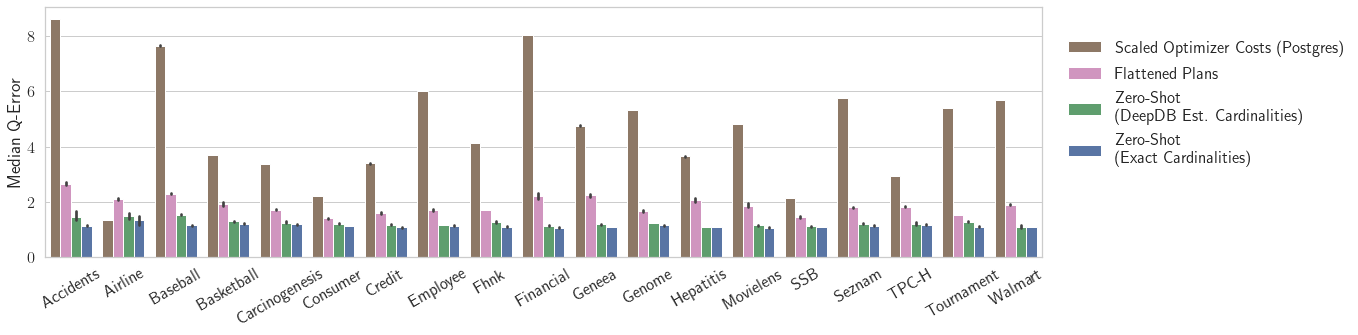

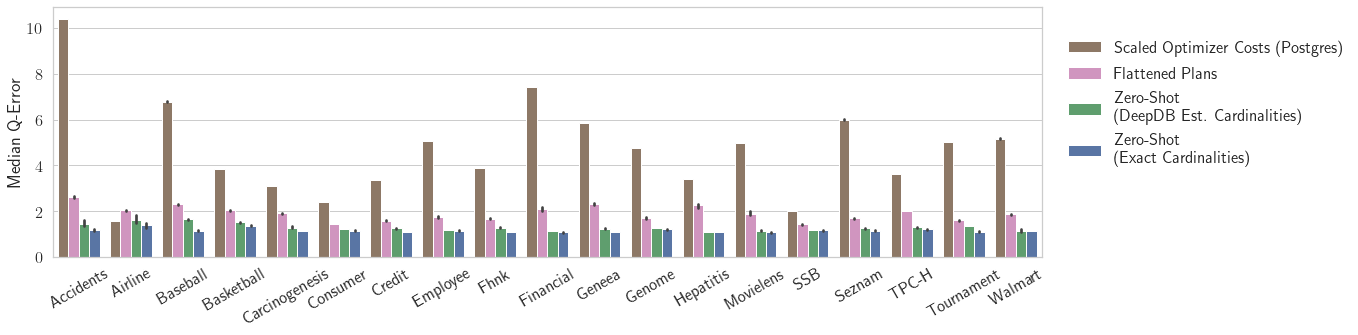

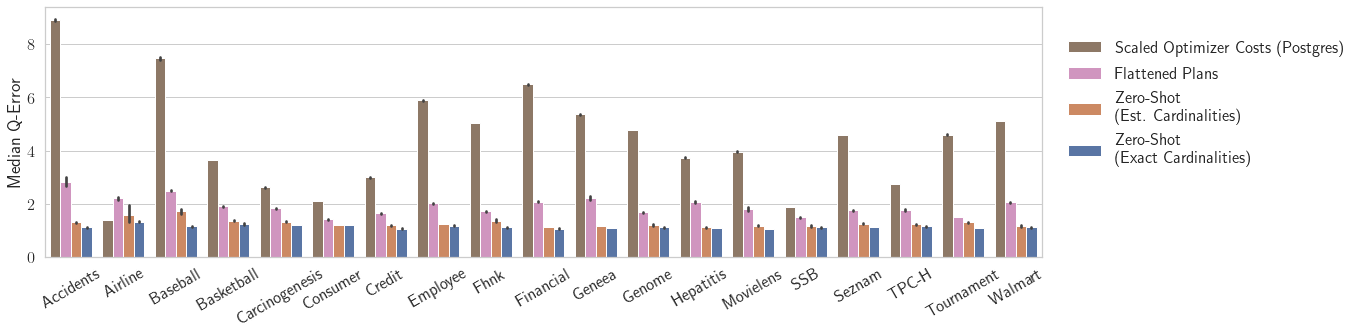

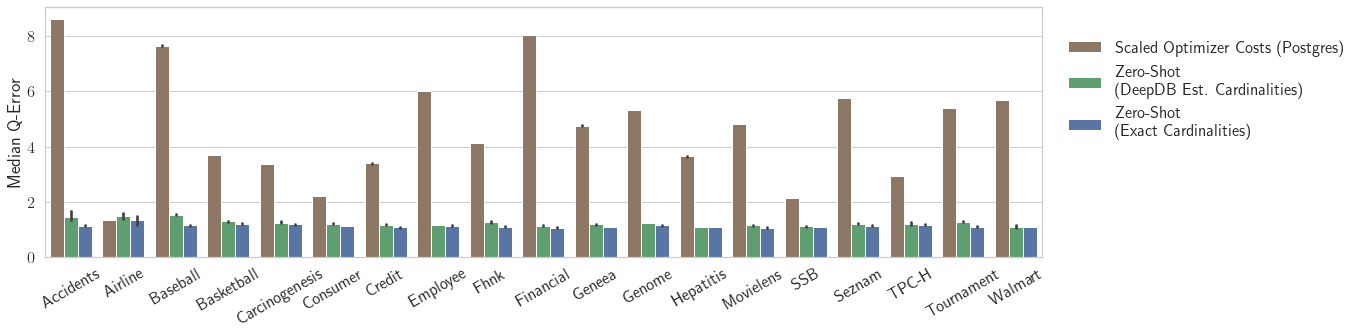

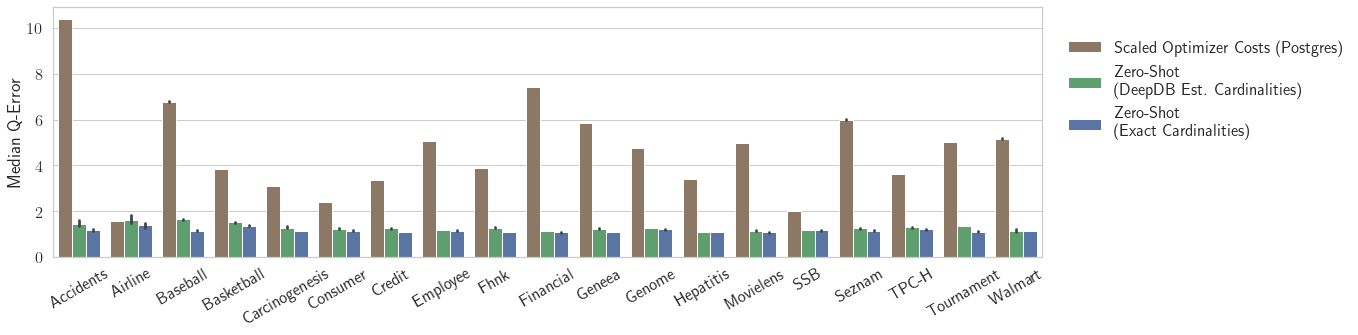

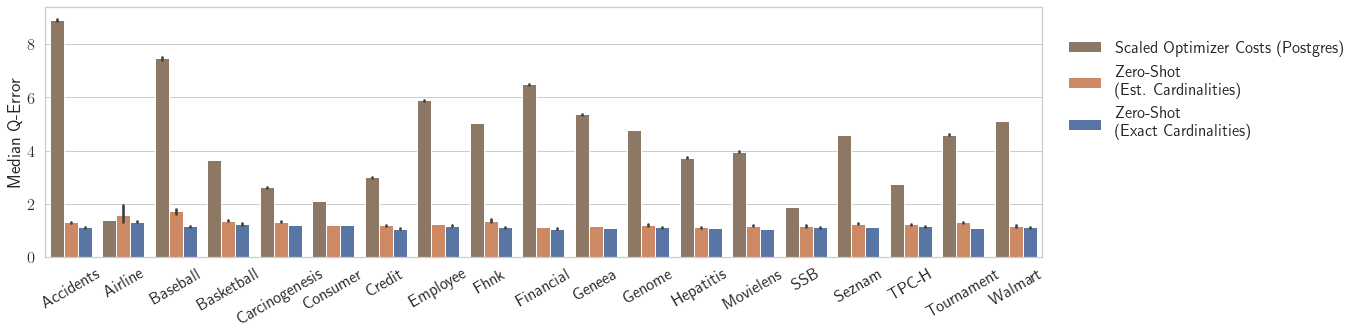

In [5]:
x = 'dataset'
hue = 'approach'
base_approach_list = [Approaches.Optimizer, Approaches.ZeroShotDeepDB, Approaches.ZeroShotExact]
base_flatten_approach_list = [Approaches.Optimizer, Approaches.LightGBM, Approaches.ZeroShotDeepDB,
                              Approaches.ZeroShotExact]

for flattened in [True, False]:

    if flattened:
        app_list = base_flatten_approach_list
    else:
        app_list = base_approach_list

    for workload in ['workload', 'index', 'complex']:

        if workload == 'complex':
            app_list = copy(app_list)
            app_list.remove(Approaches.ZeroShotDeepDB)
            app_list.insert(-1, Approaches.ZeroShotEst)

        model_names, labels, palette = get_plotting_info(app_list)

        # for y in ['val_median_q_error_50', 'val_median_q_error_95', 'val_median_q_error_100']:
        for y in ['val_median_q_error_50']:
            plt.figure(figsize=(15, 5))
            # plt.title(workload)
            df_curr = df_generalization[df_generalization.workload == workload]
            df_curr = df_curr[df_curr.dataset != 'imdb']
            df_curr = df_curr.replace({"dataset": repl_ds})

            df_curr = prepare_df(df_curr, model_names, labels)

            by_ds = sns.barplot(data=df_curr, x=x, hue=hue, y=y, palette=palette)
            for item in by_ds.get_xticklabels():
                item.set_rotation(30) # 70
            if y != 'val_median_q_error_50':
                plt.yscale('log')

            # ax.set_xscale('log')
            # plt.gca().set(ylim=(1, None))
            # plt.gca().set_xlabel('Dataset')
            plt.gca().set_xlabel(None)
            plt.gca().set_ylabel('Median Q-Error')

            plt.tight_layout()

            by_ds.legend_.set_title(None)
            plt.legend(bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0., frameon=False)

            path = f'paper_plots/db_generalization_{workload}{"_flatten" if flattened else ""}.pdf'
            os.makedirs(os.path.dirname(path), exist_ok=True)
            plt.savefig(path, bbox_inches='tight')

            plt.show()

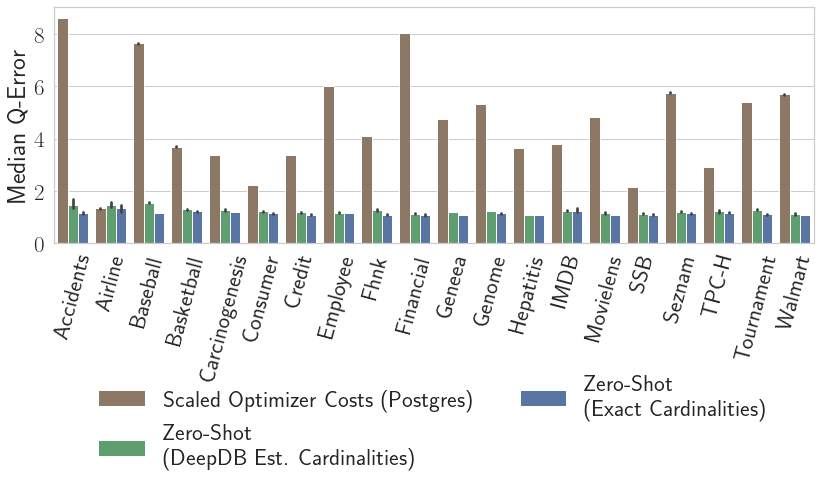

In [6]:
sns.set_theme(style="whitegrid", font_scale=2.1)
x = 'dataset'
hue = 'approach'
base_approach_list = [Approaches.Optimizer, Approaches.ZeroShotDeepDB, Approaches.ZeroShotExact]
base_flatten_approach_list = [Approaches.Optimizer, Approaches.LightGBM, Approaches.ZeroShotDeepDB,
                              Approaches.ZeroShotExact]


flattened = False
app_list = base_approach_list
workload = 'workload'
model_names, labels, palette = get_plotting_info(app_list)

# for y in ['val_median_q_error_50', 'val_median_q_error_95', 'val_median_q_error_100']:
for y in ['val_median_q_error_50']:
    plt.figure(figsize=(12, 6))
    # plt.title(workload)
    df_curr = df_generalization[df_generalization.workload == workload]
    # df_curr = df_curr[df_curr.dataset != 'imdb']
    df_curr = df_curr.replace({"dataset": repl_ds})

    df_curr = prepare_df(df_curr, model_names, labels)

    by_ds = sns.barplot(data=df_curr, x=x, hue=hue, y=y, palette=palette)
    for item in by_ds.get_xticklabels():
       item.set_rotation(75)
    if y != 'val_median_q_error_50':
        plt.yscale('log')

    # ax.set_xscale('log')
    # plt.gca().set(ylim=(1, None))
    plt.gca().set_ylabel('Median Q-Error')
    plt.gca().set_xlabel(None)

    plt.tight_layout()

    by_ds.legend_.set_title(None)
    # plt.legend(bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0., frameon=False)
    plt.legend(bbox_to_anchor=(0.5, -1.0), ncol=2, loc='lower center', borderaxespad=0., frameon=False)

    path = f'paper_plots/db_generalization_swapped_{workload}{"_flatten" if flattened else ""}.pdf'
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, bbox_inches='tight')

    plt.show()


<ipython-input-5-9f64c192d9e6>:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


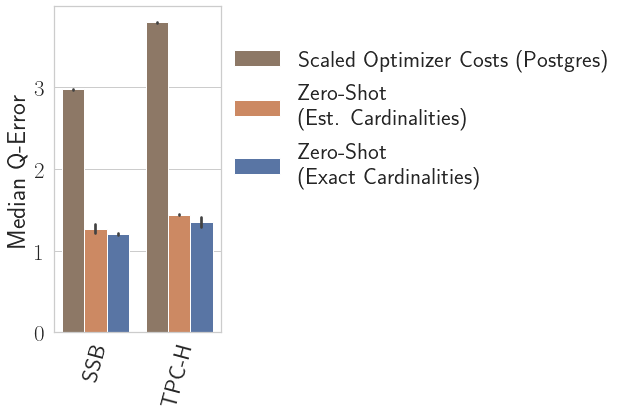

In [5]:
sns.set_theme(style="whitegrid", font_scale=2.1)
x = 'dataset'
hue = 'approach'
# base_approach_list = [Approaches.Optimizer, Approaches.LightGBM, Approaches.AnalyticalEstCard, Approaches.AnalyticalActCard, Approaches.ZeroShotEst, Approaches.ZeroShotExact]
base_approach_list = [Approaches.Optimizer, Approaches.ZeroShotEst, Approaches.ZeroShotExact]
base_flatten_approach_list = [Approaches.Optimizer, Approaches.LightGBM, Approaches.ZeroShotDeepDB,
                              Approaches.ZeroShotExact]


flattened = False
app_list = base_approach_list
workload = 'benchmark_short_running'
model_names, labels, palette = get_plotting_info(app_list)

# for y in ['val_median_q_error_50', 'val_median_q_error_95', 'val_median_q_error_100']:
for y in ['val_median_q_error_50']:
    plt.figure(figsize=(3, 6))
    # plt.title(workload)
    df_curr = df_generalization[df_generalization.workload == workload]
    # df_curr = df_curr[df_curr.dataset != 'imdb']
    df_curr = df_curr.replace({"dataset": repl_ds})

    df_curr = prepare_df(df_curr, model_names, labels)

    by_ds = sns.barplot(data=df_curr, x=x, hue=hue, y=y, palette=palette)
    for item in by_ds.get_xticklabels():
       item.set_rotation(75)
    if y != 'val_median_q_error_50':
        plt.yscale('log')

    # ax.set_xscale('log')
    # plt.gca().set(ylim=(1, None))
    plt.gca().set_ylabel('Median Q-Error')
    plt.gca().set_xlabel(None)

    plt.tight_layout()

    by_ds.legend_.set_title(None)
    plt.legend(bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0., frameon=False)
    # plt.legend(bbox_to_anchor=(0.5, -1.0), ncol=2, loc='lower center', borderaxespad=0., frameon=False)

    path = f'paper_plots/synth_benchmark_swapped_{workload}{"_flatten" if flattened else ""}.pdf'
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, bbox_inches='tight')

    plt.show()


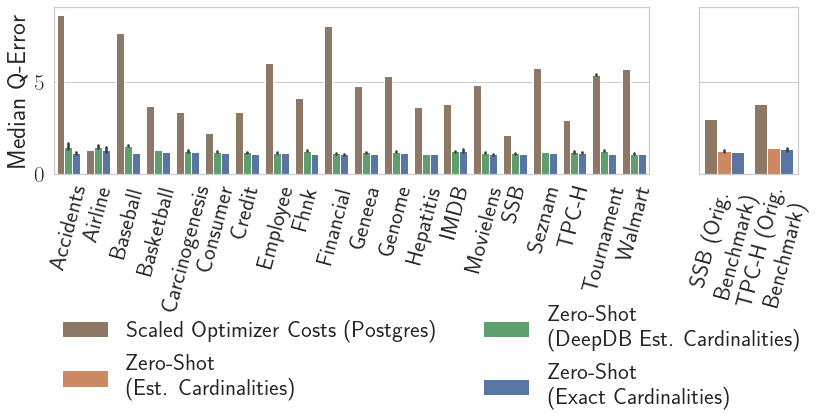

In [51]:
sns.set_theme(style="whitegrid", font_scale=2.1)
x = 'dataset'
hue = 'approach'

flattened = False
app_list = [Approaches.Optimizer, Approaches.ZeroShotDeepDB, Approaches.ZeroShotExact]
workload = 'workload'
model_names, labels, palette = get_plotting_info(app_list)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [6, 1]}, sharey=True)

# AX 0
df_curr = df_generalization[df_generalization.workload == workload]
df_curr = df_curr.replace({"dataset": repl_ds})

df_curr = prepare_df(df_curr, model_names, labels)

ax = axes[0]
by_ds = sns.barplot(ax=ax,data=df_curr, x=x, hue=hue, y='val_median_q_error_50', palette=palette)
for item in by_ds.get_xticklabels():
   item.set_rotation(75)

handles1, labels1 = ax.get_legend_handles_labels()
ax.get_legend().remove()

ax.set_ylabel('Median Q-Error')
ax.set_xlabel(None)

# AX 2
ax = axes[1]

flattened = False
app_list = [Approaches.Optimizer, Approaches.ZeroShotEst, Approaches.ZeroShotExact]
workload = 'benchmark_short_running'
model_names, labels, palette = get_plotting_info(app_list)

df_curr = df_generalization[df_generalization.workload == workload]
df_curr = df_curr.replace({"dataset": {
    'ssb': 'SSB (Orig. \n Benchmark)',
    'tpc-h': 'TPC-H (Orig.\n Benchmark)'
}})
# df_curr = df_curr.replace({"dataset": repl_ds})

df_curr = prepare_df(df_curr, model_names, labels)

by_ds = sns.barplot(ax=ax,data=df_curr, x=x, hue=hue, y='val_median_q_error_50', palette=palette)
for item in by_ds.get_xticklabels():
   item.set_rotation(75)

ax.set_ylabel(None)
ax.set_xlabel(None)
# ax.set_title("Original \nBenchmark")

handles2, labels2 = ax.get_legend_handles_labels()
ax.get_legend().remove()

plt.tight_layout()

hl_dict = {l:hl for hl,l in zip(handles1,labels1)}
hl_dict.update({l:hl for hl,l in zip(handles2,labels2)})

_, labels, _ = get_plotting_info([Approaches.Optimizer, Approaches.ZeroShotEst, Approaches.ZeroShotDeepDB, Approaches.ZeroShotExact])

leg = fig.legend([hl_dict[l] for l in labels], labels, bbox_to_anchor=(0.5, -0.0), ncol=2, loc='lower center', borderaxespad=0., frameon=False)
fig.subplots_adjust(bottom=0.55)

path = f'paper_plots/db_generalization_swapped_{workload}{"_flatten" if flattened else ""}.pdf'
os.makedirs(os.path.dirname(path), exist_ok=True)
plt.savefig(path, bbox_inches='tight')
plt.show()